In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


**Data Loading and Preprocessing**

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.42MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 153kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.81MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.2MB/s]


**Model Architecture**

In [ ]:
class DeepFeedforwardNN(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128], num_classes=10, activation='relu'):
        super(DeepFeedforwardNN, self).__init__()

        layers = []
        prev_size = input_size

        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            elif activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.network(x)

model = DeepFeedforwardNN().to(device)
print(model)

DeepFeedforwardNN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


**Training Setup**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100. * correct / total

def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return 100. * correct / total

**Train and Evaluation**

Epoch 1/10 | Loss: 0.5247 | Train Acc: 80.83% | Test Acc: 84.67%
Epoch 2/10 | Loss: 0.3728 | Train Acc: 86.32% | Test Acc: 86.52%
Epoch 3/10 | Loss: 0.3336 | Train Acc: 87.58% | Test Acc: 86.58%
Epoch 4/10 | Loss: 0.3063 | Train Acc: 88.63% | Test Acc: 86.91%
Epoch 5/10 | Loss: 0.2875 | Train Acc: 89.36% | Test Acc: 86.75%
Epoch 6/10 | Loss: 0.2737 | Train Acc: 89.82% | Test Acc: 88.17%
Epoch 7/10 | Loss: 0.2552 | Train Acc: 90.41% | Test Acc: 88.62%
Epoch 8/10 | Loss: 0.2432 | Train Acc: 90.86% | Test Acc: 88.51%
Epoch 9/10 | Loss: 0.2314 | Train Acc: 91.22% | Test Acc: 88.00%
Epoch 10/10 | Loss: 0.2184 | Train Acc: 91.78% | Test Acc: 88.87%


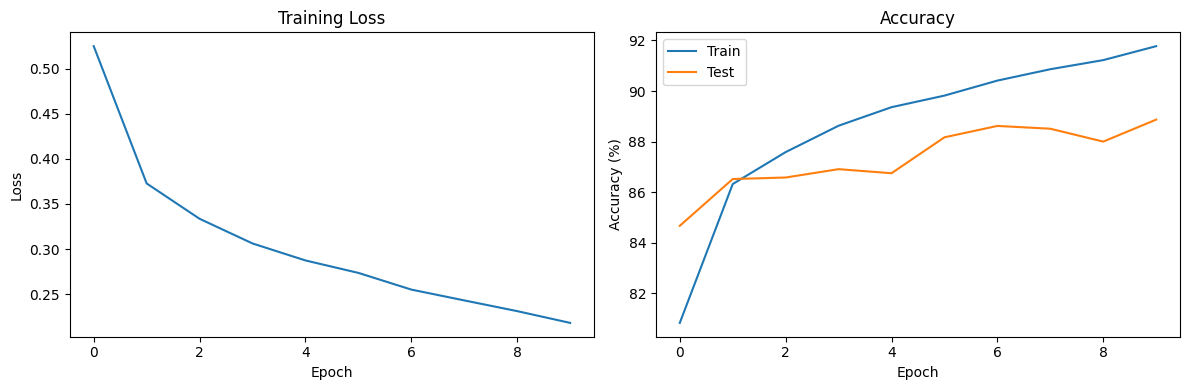

In [ ]:
num_epochs = 10
train_losses, train_accuracies, test_accuracies = [], [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    test_acc = evaluate(model, test_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

**Forward and Backward Pass Explanation**

**Forward Pass: Input → Linear → ReLU → ... → Linear → Output**

 -Transforms input through weighted connections

 -ReLU introduces non-linearity: max(0, x)

 -Final layer produces logits for each class

**Backward Pass: Loss gradient flows backward**

 -Computes ∂Loss/∂weights using chain rule

 -Updates weights: w = w - lr * ∂Loss/∂w

 -Enables learning optimal parameters

**Task 1: Network Depth and Width Experiment**


=== Training Shallow Network ===
Shallow Network Test Accuracy: 87.59%

=== Training Medium Network ===
Medium Network Test Accuracy: 87.38%

=== Training Deep Network ===
Deep Network Test Accuracy: 86.61%


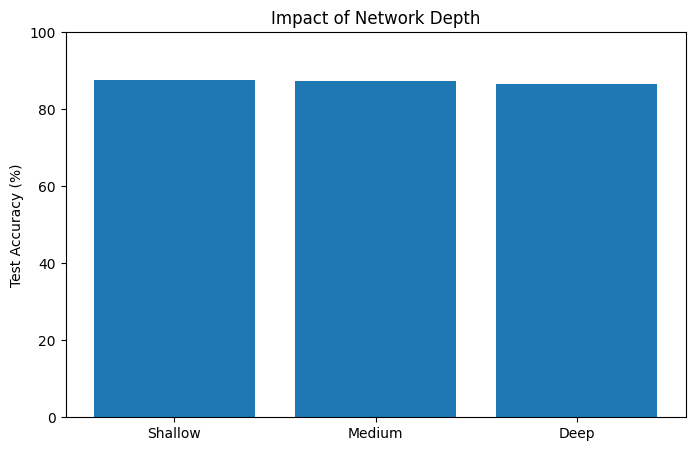

In [ ]:
configurations = {
    'Shallow': [256],
    'Medium': [512, 256, 128],
    'Deep': [512, 256, 128, 64, 32]
}

results = {}
for name, hidden_sizes in configurations.items():
    print(f'\n=== Training {name} Network ===')
    model = DeepFeedforwardNN(hidden_sizes=hidden_sizes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    test_acc = evaluate(model, test_loader)
    results[name] = test_acc
    print(f'{name} Network Test Accuracy: {test_acc:.2f}%')

plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values())
plt.ylabel('Test Accuracy (%)')
plt.title('Impact of Network Depth')
plt.ylim(0, 100)
plt.show()

**Task 2: Activation Function**


=== Training with RELU ===
RELU Test Accuracy: 86.73%

=== Training with SIGMOID ===
SIGMOID Test Accuracy: 87.44%

=== Training with TANH ===
TANH Test Accuracy: 86.95%

=== Training with LEAKY_RELU ===
LEAKY_RELU Test Accuracy: 87.32%


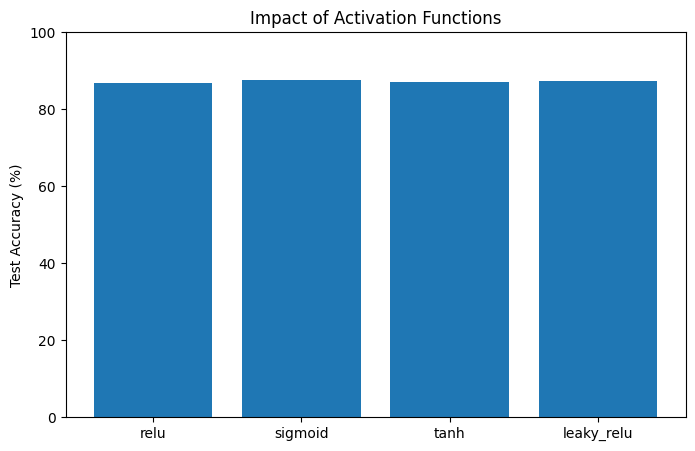


=== Activation Function Analysis ===
ReLU: Fast, no vanishing gradient, sparse activations
Sigmoid: Vanishing gradient problem in deep networks
Tanh: Zero-centered but still vanishing gradient
Leaky ReLU: Addresses dying ReLU problem


In [ ]:
activations = ['relu', 'sigmoid', 'tanh', 'leaky_relu']
activation_results = {}

for activation in activations:
    print(f'\n=== Training with {activation.upper()} ===')
    model = DeepFeedforwardNN(activation=activation).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(5):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)

    test_acc = evaluate(model, test_loader)
    activation_results[activation] = test_acc
    print(f'{activation.upper()} Test Accuracy: {test_acc:.2f}%')

plt.figure(figsize=(8, 5))
plt.bar(activation_results.keys(), activation_results.values())
plt.ylabel('Test Accuracy (%)')
plt.title('Impact of Activation Functions')
plt.ylim(0, 100)
plt.show()

print("\n=== Activation Function Analysis ===")
print("ReLU: Fast, no vanishing gradient, sparse activations")
print("Sigmoid: Vanishing gradient problem in deep networks")
print("Tanh: Zero-centered but still vanishing gradient")
print("Leaky ReLU: Addresses dying ReLU problem")

**Task 3: Hidden Layer Visualization**

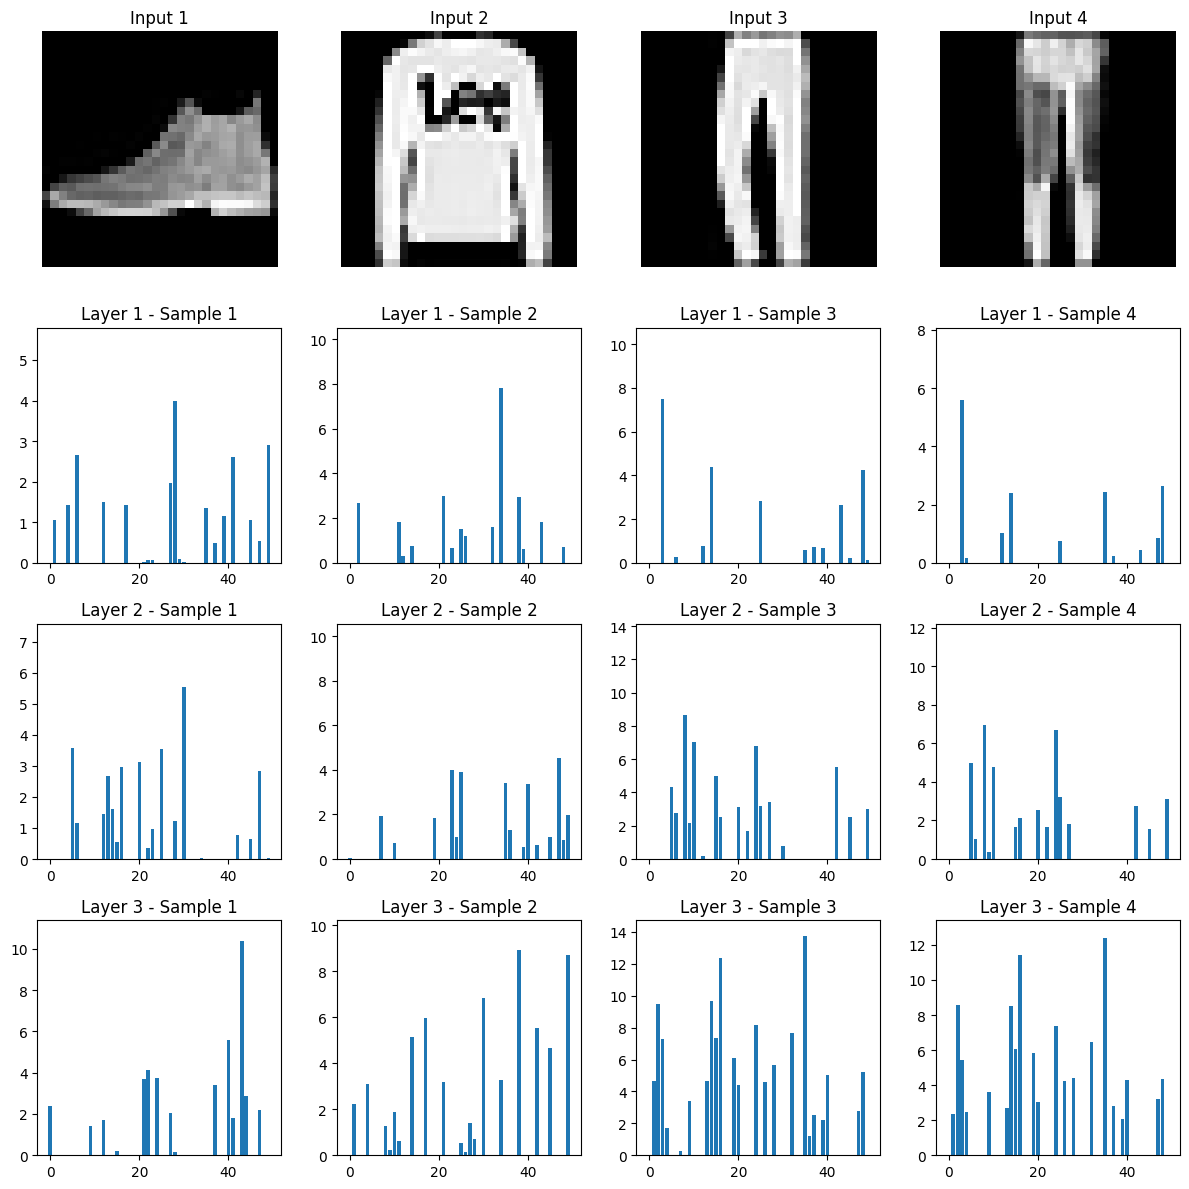


=== Feature Transformation Analysis ===
Layer 1: Detects basic edges and textures
Layer 2: Combines edges into shapes and patterns
Layer 3: Recognizes complex features (sleeves, collars)
Output: Maps features to class probabilities


In [ ]:
model.eval()
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:4].to(device)

activations = []
hooks = []

def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach())
    return hook

for i, layer in enumerate(model.network):
    if isinstance(layer, (nn.ReLU, nn.Sigmoid, nn.Tanh, nn.LeakyReLU)):
        hooks.append(layer.register_forward_hook(get_activation(f'layer_{i}')))

with torch.no_grad():
    _ = model(sample_images)

for hook in hooks:
    hook.remove()

fig, axes = plt.subplots(len(activations) + 1, 4, figsize=(12, 3 * (len(activations) + 1)))

for i in range(4):
    axes[0, i].imshow(sample_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title(f'Input {i+1}')
    axes[0, i].axis('off')

for layer_idx, activation in enumerate(activations):
    for i in range(4):
        act = activation[i].cpu().numpy()
        axes[layer_idx + 1, i].bar(range(min(50, len(act))), act[:50])
        axes[layer_idx + 1, i].set_title(f'Layer {layer_idx+1} - Sample {i+1}')
        axes[layer_idx + 1, i].set_ylim(0, act.max() + 1)

plt.tight_layout()
plt.show()

print("\n=== Feature Transformation Analysis ===")
print("Layer 1: Detects basic edges and textures")
print("Layer 2: Combines edges into shapes and patterns")
print("Layer 3: Recognizes complex features (sleeves, collars)")
print("Output: Maps features to class probabilities")

**Hyperparameter Impact**

*Learning Rate:*

-Too high: unstable training, overshooting

-Too low: slow convergence, gets stuck

-Optimal: 0.001-0.01 for Adam

*Batch Size:*

-Small (32): noisy gradients, better generalization

-Large (256): stable gradients, faster training

-Trade-off: memory vs convergence

*Number of Epochs:*

-Too few: underfitting

-Too many: overfitting on training data

-Monitor validation loss for early stopping

In [ ]:
print("\nSummary")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")
print(f"Total Parameters: {sum(p.numel() for p in model.parameters())}")


Summary
Final Test Accuracy: 88.87%
Total Parameters: 567434


**Key Findings:**

1. Deep networks learn hierarchical features

2. ReLU enables efficient training in deep networks

3. Cross-entropy loss provides proper gradients for classification

4. Adam optimizer adapts learning rates per parameter

5. Proper depth improves accuracy but risks overfitting